Utilities
============

**This notebook demonstrates the following functionality in Underworld:**

1. Evaluating Volumes integrals
2. Evaluating Surface integrals
3. Checkpoing, a.k.a saving and loading data
4. Writing XDMF files

**Keywords:** checkpointing, utilities, volume integrals, surface integrals, xdmf



In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

**Setup basic system**

Make up some temperature and velocity field examples.

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (32, 32), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )

boxMid = (0.5, 0.5)
alpha = 4.0
tempMax = 1.0
velMax = 1.0
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = tempMax * (1. - coord[1])
    
    xoffset = (coord[0]-boxMid[0], coord[1]-boxMid[1])
    r2      = xoffset[0]*xoffset[0] + xoffset[1]*xoffset[1]
    
    theta   = math.atan2(xoffset[1], xoffset[0])
    vmag    = velMax * math.exp(-(r2*alpha)**2.0)
    
    velocityField.data[index][0] = vmag  * (math.sin( theta ))
    velocityField.data[index][1] = -vmag * (math.cos( theta ))

Plot temperature and velocity field


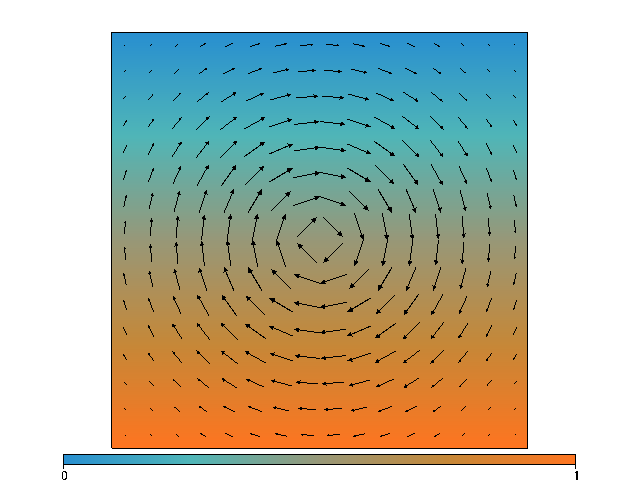

In [3]:
fig1 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField/(1.5*velMax), arrowHead=0.2, scaling=0.1) )
fig1.append( glucifer.objects.Surface( mesh, temperatureField ) )
fig1.show()

Evaluating Volume integrals
-------

To demonstrate we will evaluate the **root mean squared** (RMS) velocity, defined by: 
\\[
\begin{aligned}
v_{rms} & =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

using the `Integral` class, which coordinates both the numerical integration and parallelism required. 



In [4]:
vdotv = fn.math.dot( velocityField, velocityField )
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

A function is created to define an integrand, eg. $ {\bf v} \cdot {\bf v} $, which is passed into the `Integral` class along with the mesh that discretises the domain.  
The integrand is integrated over each element of the mesh and the results are summed to evaluate the domain integral.  
   
A combination of ``Integral``s is used to evalute the RMS velocity.

In [5]:
v2sum  = v2sum_integral.evaluate()
volume = volume_integral.evaluate()
v_rms  = math.sqrt( v2sum[0] )/volume[0]
print('RMS velocity = {0:.3f}'.format(v_rms))

RMS velocity = 0.691


**Volume integral of a subsection**

To evaluate an integral over a subsection we use the ``fn.branching.conditionl()`` to evaluate to zero when outside our subsection and non-zero inside our subsection. Here we demonstrate by calculating a circle's area.

In [6]:
# parameters for a circle.
sphereRadius = 0.1
sphereCentre = (0.5, 0.5)

def circleFnGenerator(centre, radius):
    # if fn.coord() is inside circle return True ; otherwise False
    coord    = fn.coord()
    offsetFn = coord - centre
    return     fn.math.dot( offsetFn, offsetFn ) < radius**2

# setup a function that is 1 if the coordinates, are inside the circle, and zero otherwise.
conditions     = [ ( circleFnGenerator( sphereCentre, sphereRadius) , 1.0), 
                   ( True                                           , 0.0) ]
kernelFunction = fn.branching.conditional( conditions )

Integrating over this function, over the entire mesh, will give the area of the circle ($\pi r^2$).

In [7]:
area            = math.pi * (sphereRadius**2.0)
volume_integral = uw.utils.Integral( mesh=mesh, fn=kernelFunction )
volume          = volume_integral.evaluate()
print('Mesh resolution    = {0:4d}'.format(mesh.elementRes[0]))
print('Area from integral = {0:6.8e}'.format(volume[0]))
print('Area from theory   = {0:6.8e}'.format(area))
print('Error |(int-th)|   = {0:6.8e}'.format(math.fabs(volume[0] - area)) )


Mesh resolution    =   32
Area from integral = 3.02734375e-02
Area from theory   = 3.14159265e-02
Error |(int-th)|   = 1.14248904e-03


**Source of error**

Notice that the area is not exactly as expected. This is due to the mesh resolution not properly resolving the edges of the circle. This effect is clear in the figure below where the relative error is plotted against the mesh resolution.
![](Figures/ResError.png)
The integral functions evaluate the function along the mesh vertices of a cartesian coordinate grid. So if the circle only has a few mesh vertices inside it then the calculated area of the circle will be very inaccurate.

**Average of a quantity over a shape**

We can use the same kernel function approach to calculate the average of a quantity (say temperature) over a specified volume/shape. This is equivalent to finding the mean of a quantity ($T$) using
$$
    T_{mean} = \int T( {\bf x} ) f( {\bf x} ) d{\bf x}
$$
where ${\bf x}$ denotes a position in space and $f({\bf x})$ is the kernel function which defines the boundary of the shape. This function can also be used to provide a weighted average.

In [8]:
volume_integral = uw.utils.Integral( mesh=mesh, fn=kernelFunction*temperatureField )
volume = volume_integral.evaluate()
print('Average temperature inside circle from integral = {0:6.8e}'.format(volume[0]))

Average temperature inside circle from integral = 1.51367188e-02


Surface integrals
------

**Nusselt number**

In convection models the Nusselt number is a useful diagnostic, measuring the ration between convective and conductive heat transfer.

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]
where $h$/$l$ is the height/length of the simulation domain.

These two integrals are solved in the following cell using the temperature field and it's associated gradient. The vertical component (in 2D) of the gradient function can be accessed by the index 1, while the horizontal (x component) is index 0.

Note that surface integrals can only be used along special set mesh indices, i.e. the boundaries.

In [9]:
nuTop    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuBottom = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Once again we activate these integrals using the ``evaluate`` function.

In [10]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 1.000000


As with the volume integral the same method of changing the function to be integrated over can be used to integrate over sub sets of the surface of interest. 

Checkpointing 
-----
Checkpointing is the process of saving sufficient data to facilitate restarting your simulations at a later stage. Note that we do not provide explicit checkpointing functionality, but instead provide the tools required for the loading and saving of heavy data. Which data items are required for restart will depend on the systems you have used and how you have constructed your models.

The following Underworld data structures have load/save functionality: 
 * `SwarmVariables` 
 * `Swarm`
 * `MeshVariables`
 * `Mesh`

All files are saved in HDF5 format.

*Note*: When saving a `SwarmVariable`, if you wish to reload the `SwarmVariable` data at a later stage, you must also save the `Swarm` for the corresponding state (generally, the same timestep). This requirement is due to the population control mechanisms swarms generally used for swarms, and also due to particles crossing process boundaries. When you come to reload the `Swarm` and `SwarmVariable`, you must load the `Swarm` **first**. Note again that the `Swarm` and `SwarmVariable` must be of corresponding state for successful reload.


In [11]:
outputPath = 'checkpointing/'
# Make output directory if necessary
import os
if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

**SwarmVariable**

Below a `Swarm` and a `SwarmVariable`, are created and saved to disk, then a new swarm loads the data from disk.


* Save the swarm data to disk using the `save()` method on the `Swarm` and `SwarmVariable` objects.  
   Note the handle object that is returned from the `save()` method. This is currently used for `xdmf()` operation, see below.
* Load the swarm data from disk using the `load()` method on the `Swarm` and `SwarmVariable` objects


**Note** : The `save()` & `load()` operations must be called collectively by all processes.


In [12]:
swarm1    = uw.swarm.Swarm(mesh)
swarm1var = swarm1.add_variable(dataType='int', count=1)
layout    = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm1,particlesPerCell=5)
swarm1.populate_using_layout(layout)

In [13]:
# evaluate kernalFunction for each particle in swarm1, record result in swarmvar1
swarm1var.data[:] = kernelFunction.evaluate(swarm1.particleCoordinates.data)


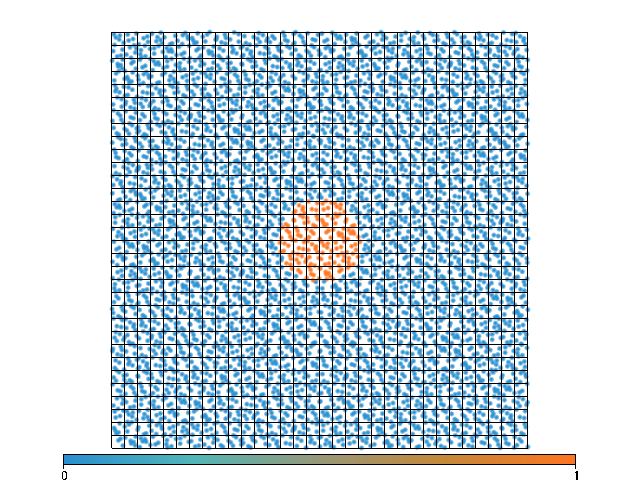

In [14]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Mesh(mesh) )
fig.append( glucifer.objects.Points(swarm1, fn_colour=swarm1var, pointSize=6.0 ) )
fig.show()

In [15]:
s1Hnd  = swarm1.save(outputPath+'swarm.h5')
s1vHnd = swarm1var.save(outputPath+'swarmvar.h5')

# new swarm
swarm2    = uw.swarm.Swarm(mesh)
swarm2var = swarm2.add_variable(dataType='int', count=1)
swarm2.load(outputPath+'swarm.h5')
swarm2var.load(outputPath+'swarmvar.h5')

In [16]:
import numpy as np
print "Are the swarm variables close? ...", np.allclose( swarm2var.data[:], swarm1var.data[:] )
print "Are the swarm particle coordinates close? ... ", np.allclose( swarm2.particleCoordinates.data[:], swarm1.particleCoordinates.data[:])

Are the swarm variables close? ... True
Are the swarm particle coordinates close? ...  True


** MeshVariables **

The `MeshVariable` object behaves similarly to `SwarmVariable` object with the `save()` and `load()` functionality.

In [17]:
mHnd   = mesh.save(outputPath+'mesh.h5')
velHnd = velocityField.save(outputPath+'velocity.h5', outputPath+'mesh.h5')

newField = uw.mesh.MeshVariable(mesh, nodeDofCount=velocityField.nodeDofCount )
newField.load(outputPath+'velocity.h5')

print "Are the mesh variables close ? ...", np.allclose( newField.data, velocityField.data )

Are the mesh variables close ? ... True


Writing to XDMF files
-----
The `XDMF` file format brings together *data* and *geometric* information in a format the can be viewed with [ParaView](http://www.paraview.org/).  
The handlers that were returned after the `save()` operations above specify this information in hdf5 format. 
 * *data* as `MeshVariable` and `SwarmVariable`
 * *geometric* as the `Mesh` and `Swarm`
 
The handlers are passed to Underworld's `XDMF` methods, along with textual names to give the Variable in the .xdmf file.


In [18]:
velocityField.xdmf(outputPath+'velocity.xdmf', velHnd, "MyField", mHnd, "TheMesh", modeltime=0.0)
swarm1var.xdmf(outputPath+'swarmvar.xdmf', s1vHnd, "SwarmVariable", s1Hnd, "TheSwarm", modeltime=0.1)


**Write XDMF file**

For more details on using XDMF write and to see it in a dynamical simulation context, see the example **1_06_Rayleigh_Taylor**.

In [19]:
if uw.rank() == 0:
    import os
    if os.path.exists(outputPath):
        os.remove(outputPath+'mesh.h5')
        os.remove(outputPath+'velocity.h5')
        os.remove(outputPath+'swarm.h5')
        os.remove(outputPath+'swarmvar.h5')
        os.remove(outputPath+'velocity.xdmf')
        os.remove(outputPath+'swarmvar.xdmf')
        os.rmdir(outputPath)